In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### 1. Hyperparameters

In [3]:
BATCH_SIZE = 512
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4  # P
NUM_CLASSES = 10  # CIFAR-10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256 # or 512 # E
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6 # transformer blocks
MLP_DIM = 512
DROP_RATE = 0.1
# num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2 : 64 # N
# x shape: torch.Size([512, 3, 32, 32])

### 2. Image transformations

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 3. Dataset

In [6]:
train_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=train_transform)

val_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=val_test_transform)

test_dataset = datasets.CIFAR10(root="data",
                                 train= False,
                                 download=True,
                                 transform=val_test_transform)

100%|██████████| 170M/170M [00:03<00:00, 47.3MB/s]


In [6]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

### 4. Data Loaders

In [9]:
train_dataset = Subset(train_dataset, range(40000))
val_dataset = Subset(val_dataset, range(40000, len(val_dataset)))

In [10]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            drop_last=True,
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [11]:
# Let's check out what we've created
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of val_loader: {len(val_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

# print("Labels from current batch:", y)

Length of train_loader: 78 batches of 512...
Length of val_loader: 19 batches of 512...
Length of test_loader: 20 batches of 512...
 Batch index: 0 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 1 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 2 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])


## Transformer

### 1. Patch Embeddings

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
      super().__init__()

      self.patch_size = patch_size
      self.proj = nn.Conv2d(in_channels= in_channels,
                            out_channels= embed_dim,
                            kernel_size=patch_size,
                            stride = patch_size)
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True) # Classification Token
      self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim), requires_grad= True) # 1, N+1, E
      self.dropout = nn.Dropout(p=0.1)

    def forward(self, x:torch.Tensor):
      B = x.size(0)
      x = self.proj(x)  # B, C, IH, IW     --> B, E, IH/P, IW/P                Split image into the patches and embed patches
      x = x.flatten(2).transpose(1, 2) # B, E, IH/P, IW/P --> B, E, (IH/P*IW/P) --> B, E, N --> B, N, E
      cls_tokens = self.cls_token.expand(B, -1, -1) # 1, 1, E --> B, 1, E
      x = torch.cat([cls_tokens, x], dim=1) # B, N+1, E i.e., [512, 65, 256]
      x = x + self.pos_embed # [B, N+1, E] +  [1, N+1, E]
      x = self.dropout(x)
      return x


In [13]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [14]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # query, key, value # returns tuple (output, attn_weights)[0]
                                                                          # output = (batch_size, seq_len, embed_dim)
                                                                          # attn_weights = (batch_size, num_heads, seq_len, seq_len)

        x = x + self.mlp(self.norm2(x))
        return x

In [15]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)       # B, N+1, E
        x = self.encoder(x)           # B, N+1, E
        x = self.norm(x)              # B, N+1, E
        cls_token = x[:, 0]           # B, E
        x = self.head(cls_token)      # B, num_classes
        return x

# Training

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS,
    MLP_DIM, DROP_RATE).to(device)

In [17]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

In [18]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [19]:
def train(model, loader, optimizer, criterion):

    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [20]:
def validate(model, loader, criterion):
    model.eval()

    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [21]:
def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [22]:
from tqdm.auto import tqdm

In [24]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in tqdm(range(EPOCHS), disable=False):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10]
Train Loss: 1.3098, Train Acc: 0.5260
Val   Loss: 1.2481, Val   Acc: 0.5254
Epoch [2/10]
Train Loss: 1.2612, Train Acc: 0.5445
Val   Loss: 1.2000, Val   Acc: 0.5467
Epoch [3/10]
Train Loss: 1.2224, Train Acc: 0.5591
Val   Loss: 1.1834, Val   Acc: 0.5539
Epoch [4/10]
Train Loss: 1.1810, Train Acc: 0.5806
Val   Loss: 1.1307, Val   Acc: 0.5756
Epoch [5/10]
Train Loss: 1.1512, Train Acc: 0.5855
Val   Loss: 1.1227, Val   Acc: 0.5771
Epoch [6/10]
Train Loss: 1.1146, Train Acc: 0.6005
Val   Loss: 1.1254, Val   Acc: 0.5818
Epoch [7/10]
Train Loss: 1.0909, Train Acc: 0.6077
Val   Loss: 1.1010, Val   Acc: 0.5848
Epoch [8/10]
Train Loss: 1.0608, Train Acc: 0.6213
Val   Loss: 1.0813, Val   Acc: 0.5956
Epoch [9/10]
Train Loss: 1.0359, Train Acc: 0.6251
Val   Loss: 1.0859, Val   Acc: 0.5940
Epoch [10/10]
Train Loss: 1.0164, Train Acc: 0.6358
Val   Loss: 1.0395, Val   Acc: 0.6122


In [27]:
test_acc = evaluate(model, test_loader)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")


🎯 Final Test Accuracy: 0.6257


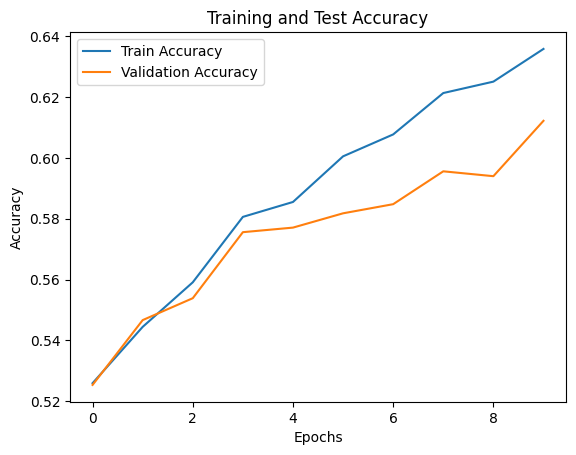

In [25]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

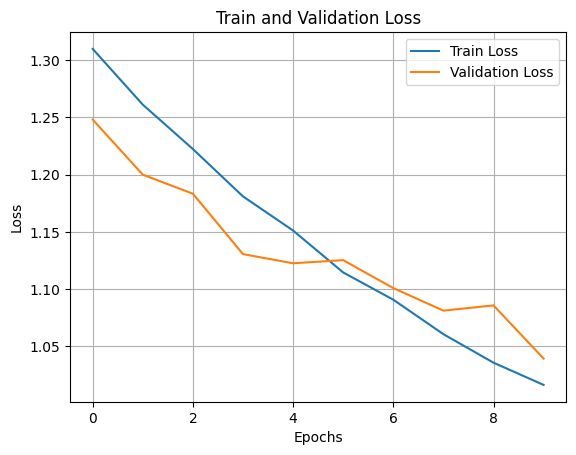

In [26]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# test_dataset[0][0].unsqueeze(dim=0).shape

In [28]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

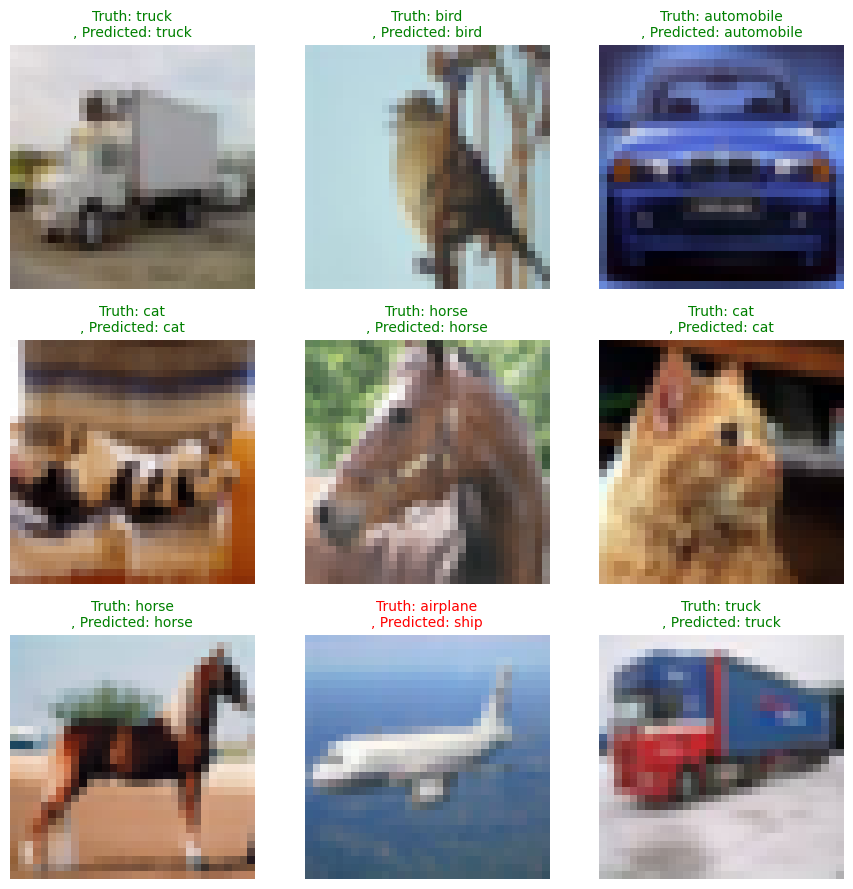

In [30]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

In [31]:
torch.save(model, "vit.pth")

In [32]:
torch.save(model.state_dict(), "vit_weights.pth")